In [3]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV   
# %pip install ydata-profiling
# %pip install ipywidgets
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

# from sklearn.ensemble import RandomForestClassifier

In [4]:
df = pd.read_csv('../data.csv')

In [5]:
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [6]:
y = df['group']
X = df.drop(['group', 'Initial_EDSS','Final_EDSS'], axis=1)
#dropear columna Initial_EDSS y Final_EDSS
df.drop(['Initial_EDSS','Final_EDSS'], axis=1, inplace=True)

In [7]:
df

,Gender,Age,Schooling,Breastfeeding,Varicella,Initial_Symptom,Mono_or_Polysymptomatic,Oligoclonal_Bands,LLSSEP,ULSSEP,VEP,BAEP,Periventricular_MRI,Cortical_MRI,Infratentorial_MRI,Spinal_Cord_MRI,group
0,1,34,20.0,1,1,2.0,1,0,1,1,0,0,0,1,0,1,1
1,1,61,25.0,3,2,10.0,2,1,1,0,1,0,0,0,0,1,1
2,1,22,20.0,3,1,3.0,1,1,0,0,0,0,0,1,0,0,1
3,2,41,15.0,1,1,7.0,2,1,0,1,1,0,1,1,0,0,1
4,2,34,20.0,2,1,6.0,2,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2,31,8.0,3,1,9.0,2,0,0,0,0,0,0,0,0,0,2
269,1,21,15.0,3,3,5.0,2,1,0,0,0,0,0,0,0,1,2
270,2,19,12.0,3,3,13.0,2,0,1,1,1,0,0,0,0,1,2
271,2,32,15.0,3,3,15.0,2,1,1,1,1,0,1,1,1,0,2


In [8]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=100)

# Dividir X_temp y y_temp en conjuntos de validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=100)


In [9]:
x_train_clean = X_train.dropna()
y_train_clean = y_train.loc[x_train_clean.index]

x_test_clean = X_test.dropna()
y_test_clean = y_test.loc[x_test_clean.index]

In [10]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [2, 4, 6, 8, 10, 12, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    "criterion": ["gini", "entropy"]
     
}


In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=100)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train_clean, y_train_clean)


best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 4032 candidates, totalling 20160 fits


KeyboardInterrupt: 

In [12]:
# guardar estos hiperparametros END bootstrap=False, criterion=entropy, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=500;
best_params = {
'bootstrap': False, 
 'criterion': 'entropy', 
 'max_depth': None, 
 'max_features': None, 
 'min_samples_leaf': 4, 
 'min_samples_split': 15, 
 'n_estimators': 500}

In [13]:
print(best_params)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 500}


Accuracy: 78.26%
Recall: 75.00%
F1: 80.00%
AUC: 78.88%


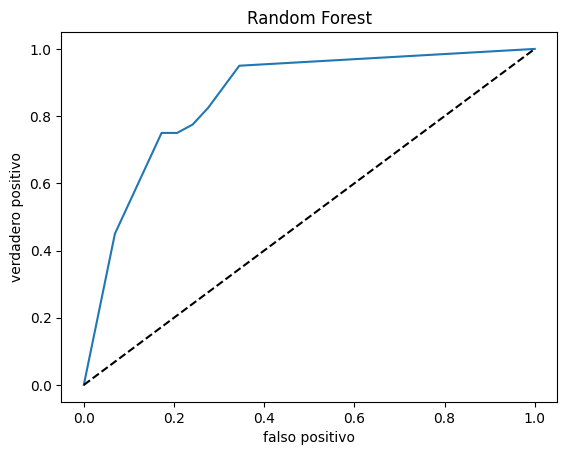

In [14]:
# Convertir los valores de y_train y y_test a {0, 1}
y_train = y_train - 1
y_test = y_test - 1

# Entrenar el modelo final con los mejores hiperparámetros 
from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

opt_model = RandomForestClassifier(**best_params)
opt_model.fit(X_train, y_train)

# Evaluar el opt_modelo y registrar métricas
y_pred = opt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
auc_score = roc_auc_score(y_test, y_pred)


#printear resultados
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1: %.2f%%" % (f1 * 100.0))
# print("AUC: %.2f%%" % (auc_score * 100.0))
print("AUC: %.2f%%" % (auc_score * 100.0))


y_prob = opt_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('falso positivo')
plt.ylabel('verdadero positivo')
plt.title("Random Forest")
#({"roc_curve": plt})
plt.show()

In [15]:
df.head(144)

,Gender,Age,Schooling,Breastfeeding,Varicella,Initial_Symptom,Mono_or_Polysymptomatic,Oligoclonal_Bands,LLSSEP,ULSSEP,VEP,BAEP,Periventricular_MRI,Cortical_MRI,Infratentorial_MRI,Spinal_Cord_MRI,group
0,1,34,20.0,1,1,2.0,1,0,1,1,0,0,0,1,0,1,1
1,1,61,25.0,3,2,10.0,2,1,1,0,1,0,0,0,0,1,1
2,1,22,20.0,3,1,3.0,1,1,0,0,0,0,0,1,0,0,1
3,2,41,15.0,1,1,7.0,2,1,0,1,1,0,1,1,0,0,1
4,2,34,20.0,2,1,6.0,2,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2,25,20.0,1,1,8.0,2,1,1,1,1,0,1,0,0,1,2
140,1,40,20.0,2,2,4.0,2,0,0,0,0,0,1,0,0,0,2
141,2,29,9.0,3,2,6.0,2,0,0,0,0,0,1,0,1,0,2
142,2,22,15.0,1,1,8.0,2,0,1,1,0,0,0,0,0,1,2


In [16]:
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc_score)

Accuracy: 0.782608695652174
Recall: 0.75
F1-score: 0.8
AUC: 0.7887931034482759


In [17]:
# Feature Importances
feature_importances = pd.DataFrame(opt_model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Periventricular_MRI,0.360650
Infratentorial_MRI,0.168310
Schooling,0.124140
LLSSEP,0.092918
Gender,0.071326
Initial_Symptom,0.066055
Breastfeeding,0.065546
Oligoclonal_Bands,0.051055
Mono_or_Polysymptomatic,0.000000
Varicella,0.000000


In [18]:
#las mas importantes
feature_importances = opt_model.feature_importances_
feature_names = X.columns

# DataFrame para las importancias de las características
importance_df = pd.DataFrame({"feature": feature_names, "importance": feature_importances})
importance_df = importance_df.sort_values(by="importance", ascending=False) 


print("Feature Importances:")
print(importance_df.head())

Feature Importances:
                feature  importance
12  Periventricular_MRI    0.360650
14   Infratentorial_MRI    0.168310
2             Schooling    0.124140
8                LLSSEP    0.092918
0                Gender    0.071326


In [19]:

# Guardar el modelo
import joblib

joblib.dump(opt_model, 'model.pkl')

# # Guardar las importancias de las características
# importance_df.to_csv('feature_importances.csv', index=False)

# # Guardar los datos de prueba
# X_test.to_csv('X_test.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)

# # Guardar los datos de entrenamiento
# X_train.to_csv('X_train.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)

# # Guardar los datos de validación
# X_val.to_csv('X_val.csv', index=False)
# y_val.to_csv('y_val.csv', index=False)

# # Guardar los datos de entrenamiento limpios
# x_train_clean.to_csv('x_train_clean.csv', index=False)
# y_train_clean.to_csv('y_train_clean.csv', index=False)

# # Guardar los datos de prueba limpios
# x_test_clean.to_csv('x_test_clean.csv', index=False)
# y_test_clean.to_csv('y_test_clean.csv', index=False)

# # Guardar los mejores hiperparámetros
# import json

# with open('best_params.json', 'w') as f:
#     json.dump(best_params, f)

# # Guardar el modelo optimizado
# joblib.dump(opt_model, 'opt_model.pkl')

# # Guardar el objeto GridSearchCV
# joblib.dump(grid_search, 'grid_search.pkl')

['model.pkl']

In [20]:
#calcular la roc auc score para train
y_train_pred = opt_model.predict(X_train)
roc_auc_score(y_train, y_train_pred)


np.float64(0.8930660888407367)

In [21]:
#roc auc score para test
y_test_pred = opt_model.predict(X_test)
roc_auc_score(y_test, y_test_pred)

np.float64(0.7887931034482759)